[*********************100%***********************]  6 of 6 completed
C:\Users\sudzxd\AppData\Local\Temp\ipykernel_3864\2851333859.py:22: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = stock_data.pct_change().dropna()


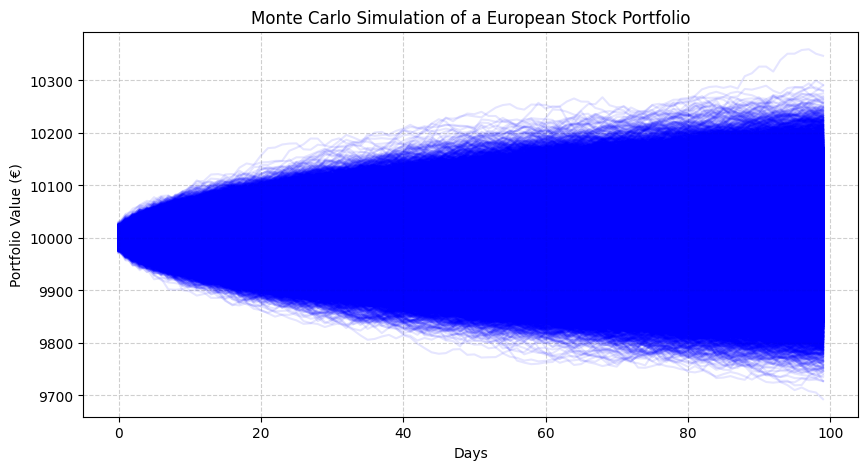

VaR_5: €115.33
CVaR_5: €144.35


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import time

# Function to fetch stock data with retries
def get_data_with_retry(stocks, start, end, retries=5, wait=30):
    for attempt in range(retries):
        try:
            stock_data = yf.download(stocks, start=start, end=end)['Close']
        except Exception as e:
            print(f"Attempt {attempt+1} failed: {e}")
            time.sleep(wait * (attempt + 1))
            continue

        if stock_data.isnull().all().all():
            print("No valid stock data returned.")
            time.sleep(wait * (attempt + 1))
            continue

        returns = stock_data.pct_change().dropna()
        mean_returns = returns.mean()
        cov_matrix = returns.cov()

        if np.any(np.isnan(cov_matrix)) or np.any(np.isinf(cov_matrix)):
            print("Covariance matrix contains invalid values.")
            time.sleep(wait * (attempt + 1))
            continue

        return mean_returns, cov_matrix, stock_data

    raise Exception("Failed to fetch stock data after multiple attempts.")

# Define European stock list
stock_list = ['SAP.DE', 'DTE.DE', 'AIR.PA', 'MC.PA', 'AZN', 'OR.PA']  # German & French stocks
start_date = '2016-01-01'
end_date = '2021-12-31'

# Fetch stock data
mean_returns, cov_matrix, stock_data = get_data_with_retry(stock_list, start_date, end_date)

# Fix Covariance Matrix if Needed
if np.any(np.linalg.eigvals(cov_matrix) <= 0):
    print("Warning: Covariance matrix is not positive semi-definite. Adjusting...")
    cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-6  # Adding a small value to the diagonal

# Generate random portfolio weights
weights = np.random.random(len(mean_returns))
weights /= np.sum(weights)

# Monte Carlo Simulation Parameters
mc_sims = 100000  # Number of simulations
T = 100  # Time horizon in days
dt = 1/252  # Daily time step (assuming 252 trading days in a year)
# Cholesky decomposition for correlated random variables
L = np.linalg.cholesky(cov_matrix)

# Monte Carlo simulation matrix
portfolio_sims = np.zeros((T, mc_sims))
initial_portfolio = 10000  # Initial portfolio value

# Monte Carlo Simulations
for m in range(mc_sims):
    # Generate random normal variables for each time step and stock
    Z = np.random.normal(size=(T, len(weights)))
    # Calculate daily returns using GBM
    daily_returns = np.exp((mean_returns.values - 0.5 * np.diag(cov_matrix)) * dt +
                           np.dot(Z, L.T) * np.sqrt(dt))
    # Adjust daily returns to start from 1
    daily_returns = np.vstack([np.ones(len(weights)), daily_returns])
    # Calculate cumulative returns
    cumulative_returns = daily_returns.cumprod(axis=0)
    # Calculate portfolio value over time
    portfolio_values = initial_portfolio * np.dot(cumulative_returns, weights)
    # Store the portfolio values for the last time step
    portfolio_sims[:, m] = portfolio_values[1:]

# Plot the Monte Carlo simulation results
plt.figure(figsize=(10, 5))
plt.plot(portfolio_sims, alpha=0.1, color='blue')
plt.ylabel('Portfolio Value (€)')
plt.xlabel('Days')
plt.title('Monte Carlo Simulation of a European Stock Portfolio')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Value at Risk (VaR) Function
def mc_var(returns, alpha=5):
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas Series.")

# Conditional Value at Risk (CVaR) Function
def mc_cvar(returns, alpha=5):
    if isinstance(returns, pd.Series):
        var = mc_var(returns, alpha=alpha)
        return returns[returns <= var].mean()
    else:
        raise TypeError("Expected a pandas Series.")

# Compute VaR and CVaR
port_results = pd.Series(portfolio_sims[-1, :])

VaR = initial_portfolio - mc_var(port_results, alpha=5)
CVaR = initial_portfolio - mc_cvar(port_results, alpha=5)

print(f'VaR_5: €{round(VaR, 2)}')
print(f'CVaR_5: €{round(CVaR, 2)}')


In [13]:
import numpy as np
import yfinance as yf

stock_ticker = "AZN"
stock = yf.Ticker(stock_ticker)

if stock.options:
    print(f"Available options for {stock_ticker}. Expiry dates: {stock.options}")

    nearest_expiry = stock.options[0]
    print(f"Nearest expiry date: {nearest_expiry}")

    # Get option chain for nearest expiration
    option_chains = stock.option_chain(nearest_expiry)

    # Extract strike prices
    strike_prices = option_chains.calls["strike"].tolist()
    print("Available call option strike prices:")
    print(strike_prices)

    # Get latest stock price
    stock_data = stock.history(period="1d")

    if not stock_data.empty:
        s = stock_data["Close"].iloc[-1]
        print(f"Latest stock price: {s}")

        # Select the closest strike price to the stock price
        K = min(strike_prices, key=lambda x: abs(x - s))
        print(f"Selected Strike Price: {K}")
    else:
        print("Could not fetch latest stock price.")
else:
    print(f"No options data available for {stock_ticker}. Try another stock.")



Available options for AZN. Expiry dates: ('2025-04-11', '2025-04-17', '2025-04-25', '2025-05-02', '2025-05-09', '2025-05-16', '2025-06-20', '2025-07-18', '2025-09-19', '2025-10-17', '2026-01-16', '2027-01-15')
Nearest expiry date: 2025-04-11
Available call option strike prices:
[45.0, 66.0, 70.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 88.0, 95.0]
Latest stock price: 68.45999908447266
Selected Strike Price: 70.0


[*********************100%***********************]  1 of 1 completed
C:\Users\sudzxd\AppData\Local\Temp\ipykernel_7296\218990172.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S = float(stock_data.iloc[-1])  # Latest available stock price


Using expiration date: 2025-04-17
Selected Strike Price: 74.0
Market Call Option Price: $0.20
Estimated Call Option Price: $6.81 ± 0.03 (Standard Error)
Percentage Change from Market Price: 3304.33%


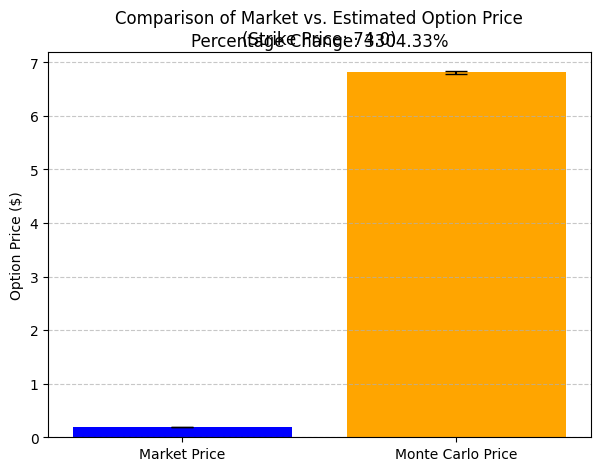

In [7]:

import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Choose a stock ticker (change if needed)
stock_ticker = "AZN"  # AstraZeneca on LSE
alternative_stock = "SAP.DE"  # SAP on German Exchange (alternative)

# Fetch Stock Price Data
stock_data = yf.download(stock_ticker, start="2025-01-01", end="2025-03-31")['Close']

if stock_data.empty:
    raise ValueError("Stock price data is empty. Check ticker symbol or data availability.")

S = float(stock_data.iloc[-1])  # Latest available stock price

# Fetch options chain for the nearest expiration date
stock = yf.Ticker(stock_ticker)

if not stock.options:
    print(f"No options data available for {stock_ticker}. Trying an alternative stock: {alternative_stock}")
    stock_ticker = alternative_stock
    stock = yf.Ticker(stock_ticker)
    if not stock.options:
        raise ValueError(f"No options data available for both {stock_ticker} and {alternative_stock}.")

expirations = stock.options  # Get list of expiration dates
nearest_expiry = expirations[0]  # Select the nearest expiration date
print(f"Using expiration date: {nearest_expiry}")

# Get option chain for the nearest expiration date
options_chain = stock.option_chain(nearest_expiry)
strike_prices = options_chain.calls["strike"].values  # List of available strikes

if len(strike_prices) == 0:
    raise ValueError("No strike prices available. Options data might be incomplete.")

# Choose a strike price closest to the stock price
K = min(strike_prices, key=lambda x: abs(x - S))
print(f"Selected Strike Price: {K}")

# Fetch the market price of the selected option
option_data = options_chain.calls  # Get call options data
market_option_price = option_data[option_data["strike"] == K]["lastPrice"].values

if len(market_option_price) == 0:
    raise ValueError(f"Market price not available for the selected strike price: {K}")

market_option_price = market_option_price[0]  # Extract the actual price
print(f"Market Call Option Price: ${market_option_price:.2f}")

# Option Parameters
vol = 0.30      # Adjusted volatility
r = 0.04        # Risk-free rate
T = 0.5         # Time in years
N = 10          # Time steps
M = 100000      # Simulations

# Precompute constants
dt = T / N
nudt = (r - 0.5 * vol**2) * dt
volsdt = vol * np.sqrt(dt)
lnS = np.log(S)

# Monte Carlo Simulation (Vectorized)
Z = np.random.normal(size=(N, M))
delta_lnSt = nudt + volsdt * Z
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
lnSt = np.concatenate((np.full(shape=(1, M), fill_value=lnS), lnSt))

# Compute Expectation and Standard Error
ST = np.exp(lnSt)
CT = np.maximum(0, ST - K)
C0 = np.exp(-r * T) * np.mean(CT[-1])

sigma = np.std(CT[-1], ddof=1)  # Sample standard deviation
SE = sigma / np.sqrt(M)

# Calculate Percentage Change
percentage_change = ((C0 - market_option_price) / market_option_price) * 100

# Print results
print(f"Estimated Call Option Price: ${C0:.2f} ± {SE:.2f} (Standard Error)")
print(f"Percentage Change from Market Price: {percentage_change:.2f}%")

# Plot Comparison
plt.figure(figsize=(7, 5))
plt.bar(["Market Price", "Monte Carlo Price"], [market_option_price, C0], 
        color=["blue", "orange"], yerr=[0, SE], capsize=8)
plt.ylabel("Option Price ($)")
plt.title(f"Comparison of Market vs. Estimated Option Price\n(Strike Price: {K})")
plt.text(0.5, max(market_option_price, C0) + 0.5, 
         f"Percentage Change: {percentage_change:.2f}%", 
         ha='center', fontsize=12, color='black')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


[*********************100%***********************]  1 of 1 completed

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    AZN   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2448.53
Distribution:                  Normal   AIC:                           4905.05
Method:            Maximum Likelihood   BIC:                           4925.78
                                        No. Observations:                 1316
Date:                Thu, Apr 17 2025   Df Residuals:                     1315
Time:                        19:42:31   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0626  4.110e-02      1.523      0.128 [-1.79

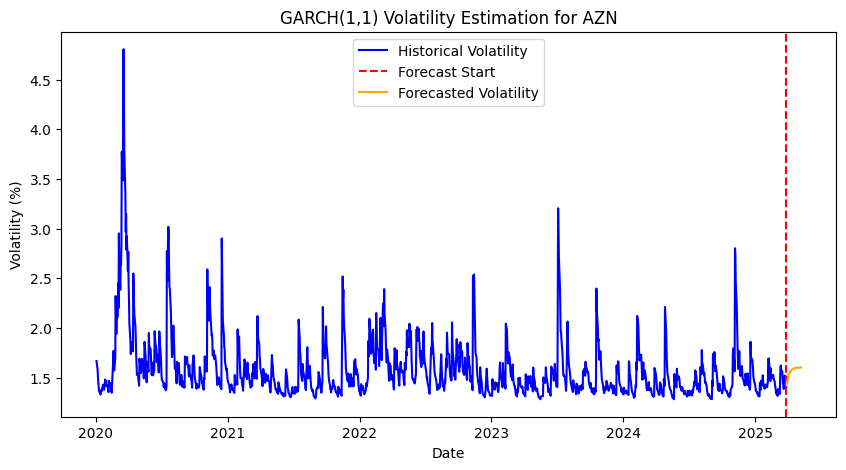

In [12]:
import numpy as np
import pandas as pd
import yfinance as yf
from arch import arch_model
import matplotlib.pyplot as plt

# Fetch stock price data
stock_ticker = "AZN"  # Example stock
start_date = "2020-01-01"
end_date = "2025-03-31"
stock_data = yf.download(stock_ticker, start=start_date, end=end_date)['Close']

if stock_data.isnull().all().all():
    raise ValueError("No valid stock data returned.")

# Compute daily returns
returns = stock_data.pct_change().dropna() * 100  # Convert to percentage

# Fit GARCH(1,1) model
garch_model = arch_model(returns, vol="Garch", p=1, q=1, dist="normal")  # p=1 (ARCH), q=1 (GARCH)
garch_results = garch_model.fit(disp="off")

# Print model summary
print(garch_results)

# Forecast volatility
forecast_horizon = 30  # 30 days ahead
garch_forecast = garch_results.forecast(start=returns.index[-1], horizon=forecast_horizon)

# Extract forecasted variance and convert to standard deviation (volatility)
forecasted_volatility = np.sqrt(garch_forecast.variance.iloc[-1])

# Plot historical volatility and forecast
plt.figure(figsize=(10, 5))
plt.plot(returns.index, garch_results.conditional_volatility, label="Historical Volatility", color='blue')

plt.axvline(returns.index[-1], color="red", linestyle="--", label="Forecast Start")
plt.plot(pd.date_range(returns.index[-1], periods=forecast_horizon, freq="B"), forecasted_volatility, 
         label="Forecasted Volatility", color='orange')
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.title(f"GARCH(1,1) Volatility Estimation for {stock_ticker}")
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed
C:\Users\sudzxd\AppData\Local\Temp\ipykernel_7296\603560802.py:53: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S = float(stock_data.iloc[-1])


=== Option Pricing Comparison ===
Latest Stock Price (S): $73.79
Selected Strike Price (K): $74.00
Real Market Option Price: $0.20
Monte Carlo Price (Fixed Volatility): $6.83
Percentage Change (Fixed Vol): 3313.48%
Monte Carlo Price (GARCH Volatility): $1.27
Percentage Change (GARCH Vol): 536.55%
Absolute Difference (Market vs Fixed Vol): $6.63
Absolute Difference (Market vs GARCH Vol): $1.07


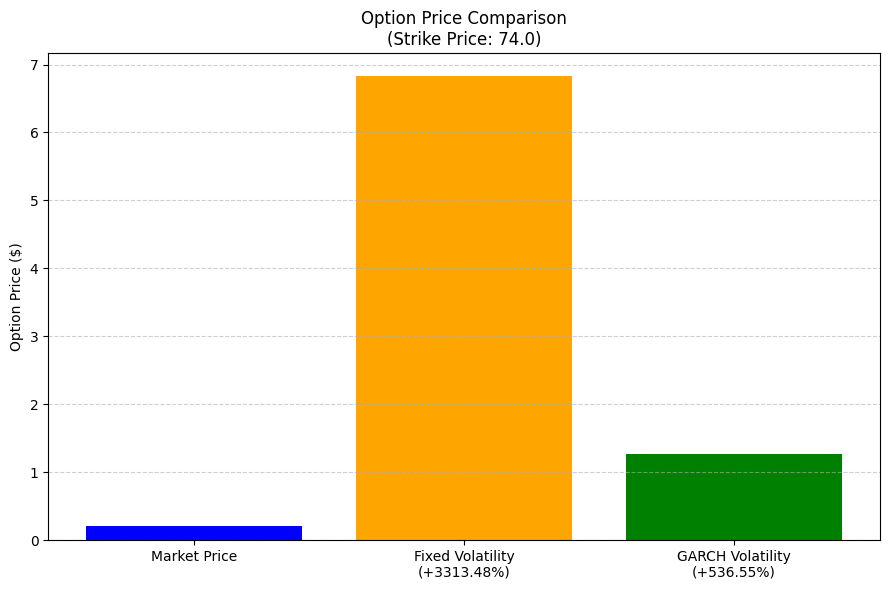

In [15]:
import numpy as np

import pandas as pd

import yfinance as yf

import matplotlib.pyplot as plt

from arch import arch_model



# Parameters

stock_ticker = "AZN"

start_date = "2020-01-01"

end_date = "2025-03-31"

T = 0.5  # Time to maturity in years

N = 10   # Number of steps

M = 1000000  # Simulations

r = 0.04  # Risk-free rate



# Fetch stock data

stock_data = yf.download(stock_ticker, start=start_date, end=end_date)['Close']

returns = stock_data.pct_change().dropna() * 100  # Daily returns in %



# Fit GARCH(1,1)

garch_model = arch_model(returns, vol="Garch", p=1, q=1)

garch_results = garch_model.fit(disp="off")

forecast = garch_results.forecast(start=returns.index[-1], horizon=N)

forecasted_vols = np.sqrt(forecast.variance.iloc[-1].values) / 100  # Convert to decimal



# Latest stock price and strike

S = float(stock_data.iloc[-1])

K = S  # At-the-money

vol = 0.30  # Fixed volatility

dt = T / N

lnS = np.log(S)



# === Try fetching the real market option price ===

stock = yf.Ticker(stock_ticker)



if not stock.options:

    raise ValueError("No option chain found for the stock.")



nearest_expiry = stock.options[0]

option_chain = stock.option_chain(nearest_expiry)

calls = option_chain.calls



# Choose strike price closest to S

calls['diff'] = abs(calls['strike'] - S)

selected_call = calls.sort_values('diff').iloc[0]

market_option_price = selected_call['lastPrice']

selected_strike = selected_call['strike']



# Monte Carlo (Fixed Volatility)

Z1 = np.random.normal(size=(N, M))

nudt1 = (r - 0.5 * vol**2) * dt

volsdt1 = vol * np.sqrt(dt)

lnSt1 = lnS + np.cumsum(nudt1 + volsdt1 * Z1, axis=0)

lnSt1 = np.vstack([np.full((1, M), lnS), lnSt1])

ST1 = np.exp(lnSt1)

CT1 = np.maximum(0, ST1[-1] - selected_strike)

C0_fixed = np.exp(-r * T) * np.mean(CT1)



# Monte Carlo (GARCH Volatility)

Z2 = np.random.normal(size=(N, M))

nudt2 = (r - 0.5 * forecasted_vols**2) * dt

volsdt2 = forecasted_vols * np.sqrt(dt)

delta_lnSt2 = nudt2[:, None] + volsdt2[:, None] * Z2

lnSt2 = lnS + np.cumsum(delta_lnSt2, axis=0)

lnSt2 = np.vstack([np.full((1, M), lnS), lnSt2])

ST2 = np.exp(lnSt2)

CT2 = np.maximum(0, ST2[-1] - selected_strike)

C0_garch = np.exp(-r * T) * np.mean(CT2)


percent_change_fixed = ((C0_fixed - market_option_price) / market_option_price) * 100

percent_change_garch = ((C0_garch - market_option_price) / market_option_price) * 100



# === Print All Results ===

print("=== Option Pricing Comparison ===")

print(f"Latest Stock Price (S): ${S:.2f}")

print(f"Selected Strike Price (K): ${selected_strike:.2f}")

print(f"Real Market Option Price: ${market_option_price:.2f}")

print(f"Monte Carlo Price (Fixed Volatility): ${C0_fixed:.2f}")

print(f"Percentage Change (Fixed Vol): {percent_change_fixed:.2f}%")

print(f"Monte Carlo Price (GARCH Volatility): ${C0_garch:.2f}")

print(f"Percentage Change (GARCH Vol): {percent_change_garch:.2f}%")

print(f"Absolute Difference (Market vs Fixed Vol): ${abs(market_option_price - C0_fixed):.2f}")

print(f"Absolute Difference (Market vs GARCH Vol): ${abs(market_option_price - C0_garch):.2f}")


plt.figure(figsize=(9, 6))

prices = [market_option_price, C0_fixed, C0_garch]

labels = [

    "Market Price", 

    f"Fixed Volatility\n({percent_change_fixed:+.2f}%)", 

    f"GARCH Volatility\n({percent_change_garch:+.2f}%)"

]

colors = ["blue", "orange", "green"]

plt.bar(labels, prices, color=colors)

plt.title(f"Option Price Comparison\n(Strike Price: {selected_strike})")

plt.ylabel("Option Price ($)")

plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()

plt.show()
